The dataset I am using was annotated using the COCO standard, for my project I do not need all the information there contained but only the position of the corn kernels and also the amount of them in each image. So in this notebook I will go through the three datasets that I have here `corn` `many` and `narrow` and will produce a csv with the number of kernels in each image and a csv with the kernel positions in pixels. This is basically the information I will need to perform the simple regression approach and also the generation of the density maps.

In [5]:
### IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pandas as pd

In [6]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"


## Narrow

In [4]:
for dataset in ["narrow","many","corn"]:
    for mode in ["train","test"]:
        # Path to the JSON file
        path_f = path + dataset + "_coco/" 
        coco_file = path_f + f"{dataset}_kernel_{mode}.json" 
        
        # read json with all the info
        with open(coco_file) as json_file:
            coco_data = json.load(json_file) 
            
        if coco_data["categories"][0]["name"]!="Kernel": print("WARNING; CATEGORIES CHANGED!!")
            
        ### Convert all image info to a dataframe 
        df_images = pd.DataFrame(coco_data["images"])
        
        # Get a dataframe with all the annotations
        df_annotations = pd.DataFrame(coco_data["annotations"])
        
        ### Add the kernel center to each anotation
        df_annotations['kernel_x'] = df_annotations.apply(lambda row: row.bbox[0]+row.bbox[2]/2, axis=1)
        df_annotations['kernel_y'] = df_annotations.apply(lambda row: row.bbox[1]+row.bbox[3]/2, axis=1)

        ### Remove useless annotations
        df_annotations = df_annotations[df_annotations['category_id'] == 26560] 

        ### Remove columns containing useless information
        df_annotations = df_annotations.drop(labels=["id","segmentation","iscrowd","category_id","bbox"], axis=1)

        ### Save csv with the kernel position information
        save_path = path_f+f"{dataset}_kernel_{mode}_positions.csv"
        df_annotations.to_csv(path_or_buf=save_path, sep=',',header=True, index=False)  
         
        ### Now I also want to keep the number of kernels in each image
        df = df_annotations["image_id"].value_counts().rename_axis('id').reset_index(name='counts')
        
        df_images = pd.merge(df_images, df, on=['id'])
        
        save_path = path_f+f"{dataset}_kernel_{mode}_info.csv"
        df_images.to_csv(path_or_buf=save_path, sep=',',header=True, index=False)
        
        ### I also want to keep the kernel numbers and the images paths
        df_regression = df_images.drop(labels=["id","height","width","license"], axis=1)
        df_regression['file_name'] = df_regression.apply(lambda row:path +dataset+"_coco/"+row.file_name, axis=1)
        
        save_path = path_f+f"{dataset}_kernel_{mode}_labels.csv"
        df_regression.to_csv(path_or_buf=save_path, sep=',',header=True, index=False)

As we only want to keep the kernels (we have no interest in the baren tip, incomplete kernels or diceased ones) we will filter the rows and only keep the ones with the code 26560.

Lets plot a few example of images just to check that the points were correctly drawn and that the number of points is the same as declared in the file.

In [4]:
image_id = 0

# selecting rows based on condition 
rslt_df = df_annotations[df_annotations['image_id'] == image_id].reset_index() 
#rslt_df

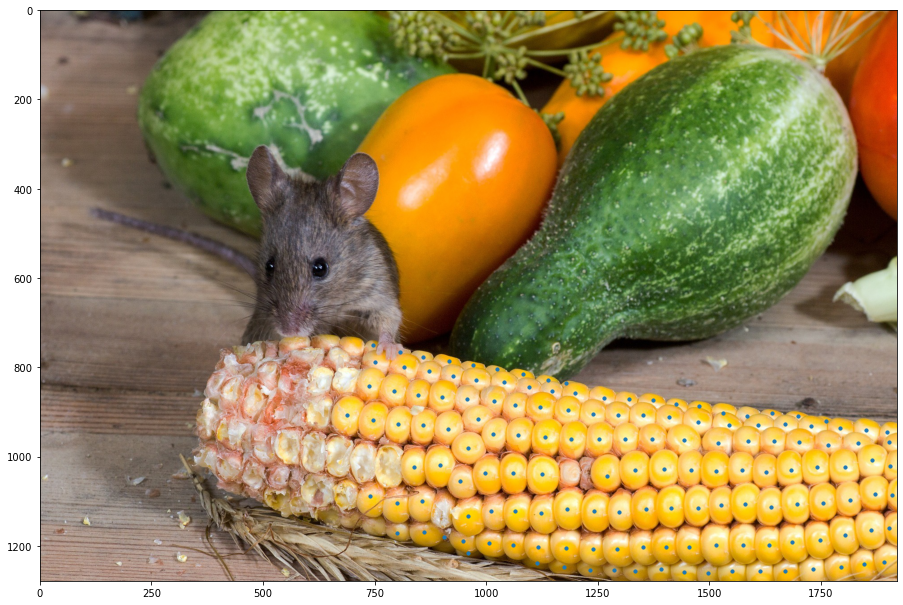

In [5]:
im = mpimg.imread(path_f+"/"+df_images[df_images['id'] == image_id]["file_name"][0])

# Create figure and axes
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)
# Display the image
ax.imshow(im)
# Create a Rectangle patch
# for i in range(len(rslt_df)):
#     rect = patches.Rectangle((rslt_df["bbox"][i][0], rslt_df["bbox"][i][1]), rslt_df["bbox"][i][2], rslt_df["bbox"][i][3], linewidth=1, edgecolor='r', facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)
plt.scatter(rslt_df["kernel_x"],rslt_df["kernel_y"],s=10)
plt.show()

Now I want to add the number of grains per picture so I can keep it as information for a regression approach.

# Inspection of the datasets properties

In [7]:
#["narrow","many","corn"]
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

df_info_corn = pd.read_csv (path + f"corn_coco/corn_kernel_train_info.csv" )
df_positions_corn = pd.read_csv (path + f"corn_coco/corn_kernel_train_positions.csv" )

df_info_many = pd.read_csv (path + f"many_coco/many_kernel_train_info.csv" )
df_positions_many = pd.read_csv (path + f"many_coco/many_kernel_train_positions.csv" )

df_info_narrow = pd.read_csv (path + f"narrow_coco/narrow_kernel_train_info.csv" )
df_positions_narrow = pd.read_csv (path + f"narrow_coco/narrow_kernel_train_positions.csv" )


## Some plots

In [8]:
def plot_samples(path,df_positions,df_info,title):
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    fig.suptitle(title,fontsize=15)
    fig.subplots_adjust(top=0.88)
    axs = axs.ravel()
    for image_id in range (4):
        rslt_df = df_positions[df_positions['image_id'] == image_id].reset_index()
        #print(path+df_info[df_info['id'] == image_id]["file_name"].tolist()[0])
        im      = mpimg.imread(path+df_info[df_info['id'] == image_id]["file_name"].tolist()[0])

        # Plot the reconstructed image  
        axs[image_id].imshow(im)
        axs[image_id].scatter(rslt_df["kernel_x"],rslt_df["kernel_y"],s=10)
        axs[image_id].set_title("")
        axs[image_id].set_xticks([])
        axs[image_id].set_yticks([])
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

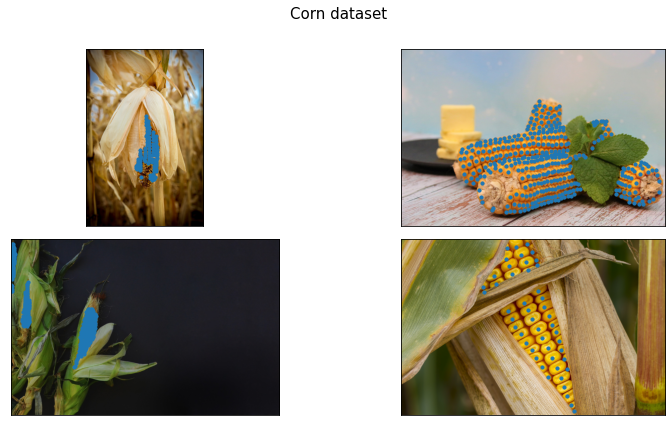

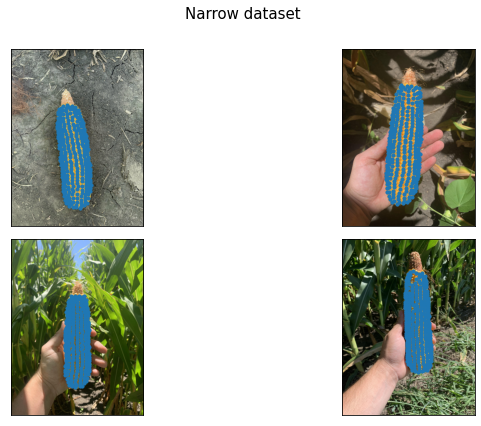

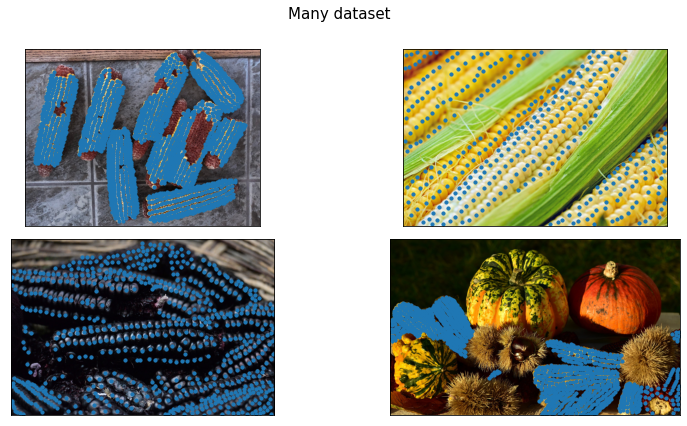

In [9]:
plot_samples(path + "corn_coco/",df_positions_corn,df_info_corn,"Corn dataset")
plot_samples(path + "narrow_coco/",df_positions_narrow,df_info_narrow,"Narrow dataset")
plot_samples(path + "many_coco/",df_positions_many,df_info_many,"Many dataset")


## kernels by image and kernel sizes

In [12]:
import numpy as np

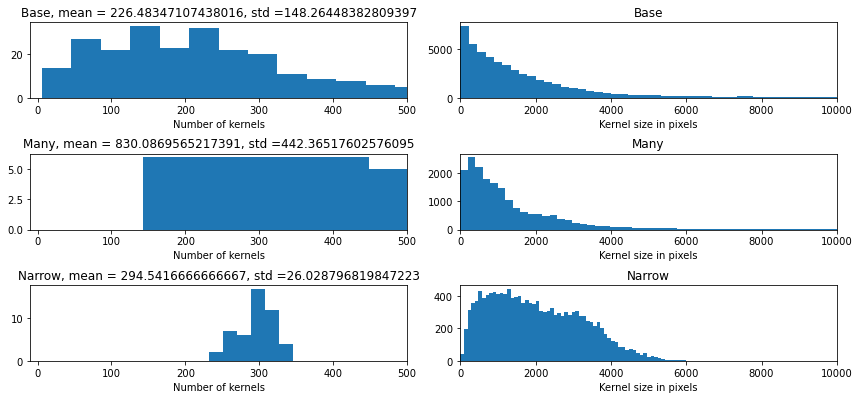

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(12,6))
fig.suptitle("",fontsize=15)

# Plot the reconstructed image
data_to_plot = list(df_positions_corn["image_id"].value_counts()) 
axs[0,0].hist(data_to_plot,bins=20)
axs[0,0].set_title(f"Base, mean = {np.mean(data_to_plot)}, std ={np.std(data_to_plot)}")
axs[0,0].set_xlim(-10,500)
axs[0,0].set_xlabel("Number of kernels")

axs[0,1].hist(list(df_positions_corn["area"]),bins=5000)
axs[0,1].set_title("Base")
axs[0,1].set_xlim(-10,10000)
axs[0,1].set_xlabel("Kernel size in pixels")

data_to_plot = list(df_positions_many["image_id"].value_counts())
axs[1,0].hist(data_to_plot,bins=6)
axs[1,0].set_title(f"Many, mean = {np.mean(data_to_plot)}, std ={np.std(data_to_plot)}")
axs[1,0].set_xlim(-10,500)
axs[1,0].set_xlabel("Number of kernels")

axs[1,1].hist(list(df_positions_many["area"]),bins=100)
axs[1,1].set_title("Many")
axs[1,1].set_xlim(-10,10000)
axs[1,1].set_xlabel("Kernel size in pixels")

data_to_plot = list(df_positions_narrow["image_id"].value_counts())
axs[2,0].hist(data_to_plot,bins=6)
axs[2,0].set_title(f"Narrow, mean = {np.mean(data_to_plot)}, std ={np.std(data_to_plot)}")
axs[2,0].set_xlim(-10,500)
axs[2,0].set_xlabel("Number of kernels")

axs[2,1].hist(list(df_positions_narrow["area"]),bins=100)
axs[2,1].set_title("Narrow")
axs[2,1].set_xlim(-10,10000)
axs[2,1].set_xlabel("Kernel size in pixels")

plt.tight_layout()
fig.subplots_adjust(top=0.88)